# Imports Necessary Modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import cv2
import joblib
import numpy as np
import seaborn as sns
from skimage import io, color
from collections import Counter
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Function for Loading and Preprocess Images

In [2]:
img_size = (1300, 650)



def load_and_preprocess_images(folder, img_size):
    images = []
    labels = []
    for subdir, _, files in os.walk(folder):
        label = subdir.split('\\')[-1]  
        for file in files:
            img_path = os.path.join(subdir, file)
            img = io.imread(img_path ,as_gray=True)  
            img_resized = resize(img, img_size, mode='reflect') 
            img_flattened = img_resized.flatten()  
            images.append(img_flattened)
            labels.append(label)
    return np.array(images), np.array(labels)

#  Data Paths

In [3]:
train_folder = "C:\\Users\\DELL 5540\\Desktop\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\train"
valid_folder = "C:\\Users\\DELL 5540\\Desktop\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\val"
test_folder = "C:\\Users\\DELL 5540\\Desktop\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\test"

# Loading and Preprocessing Image Data for Training, Validation, and Testing Sets

In [4]:
X_train, y_train = load_and_preprocess_images(train_folder, img_size)
X_valid, y_valid = load_and_preprocess_images(valid_folder, img_size)
X_test, y_test = load_and_preprocess_images(test_folder, img_size)

#  Number of Images in each Class (Train, Validation, Test)

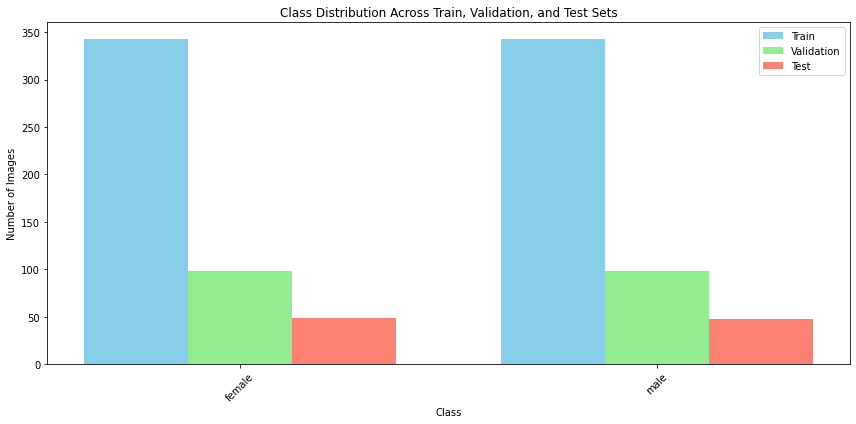

In [5]:
train_class_counts = Counter(y_train)
valid_class_counts = Counter(y_valid)
test_class_counts = Counter(y_test)

labels = sorted(set(y_train) | set(y_valid) | set(y_test))  
train_counts = [train_class_counts.get(label, 0) for label in labels]
valid_counts = [valid_class_counts.get(label, 0) for label in labels]
test_counts = [test_class_counts.get(label, 0) for label in labels]

x = np.arange(len(labels)) 
width = 0.25 

plt.figure(figsize=(12, 6))
plt.bar(x - width, train_counts, width, label='Train', color='skyblue')
plt.bar(x, valid_counts, width, label='Validation', color='lightgreen')
plt.bar(x + width, test_counts, width, label='Test', color='salmon')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution Across Train, Validation, and Test Sets')
plt.xticks(x, labels, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Data Shapes

In [6]:
print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (686, 845000)
X_valid shape: (196, 845000)
X_test shape: (97, 845000)


# Displaying Randomly Selected Images with Labels

Displaying images from the training set:


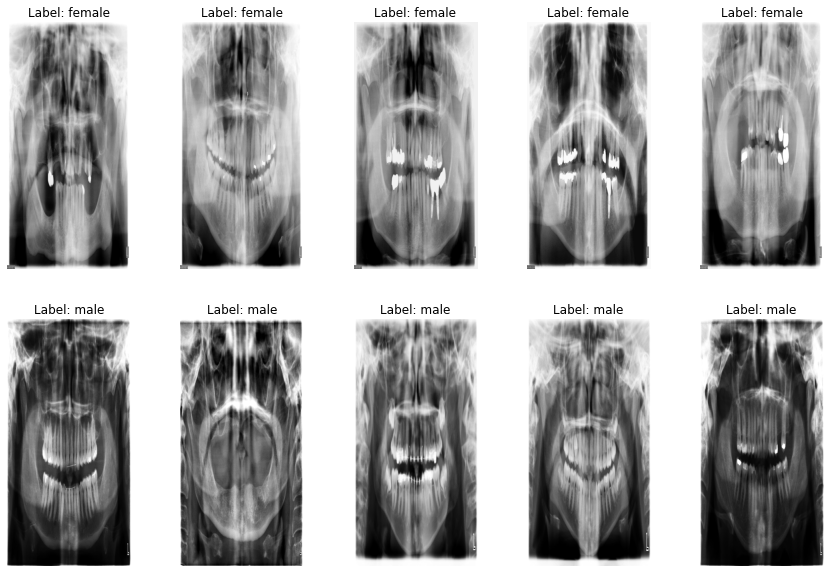

In [7]:
def display_images(images, labels, num_images=5):
    unique_labels = list(set(labels))  
    fig, axes = plt.subplots(len(unique_labels), num_images, figsize=(15, len(unique_labels) * 5))
    
    for i, label in enumerate(unique_labels):
        label_images = [img for img, lbl in zip(images, labels) if lbl == label]
        
        for j in range(num_images):
            if j < len(label_images):
                ax = axes[i, j]
                ax.imshow(label_images[j].reshape(img_size[0], img_size[1]), cmap='gray', vmin=0, vmax=1)
                ax.set_title(f"Label: {label}")
                ax.axis('off')
            else:
                axes[i, j].axis('off')
    
    plt.show()



# Display images
print("Displaying images from the training set:")
display_images(X_train, y_train)

# Combining Training and Validation Datasets for Cross Validation

In [8]:
X_combined = np.concatenate((X_train, X_valid), axis=0)
y_combined = np.concatenate((y_train, y_valid), axis=0)

# First 5 Labels before encoding

In [9]:
print("First 5 values in y_combined:") 
print(y_combined[:5])

First 5 values in y_combined:
['female' 'female' 'female' 'female' 'female']


# Encoding Labels Using LabelEncoder

In [10]:
le = LabelEncoder()
y_combined_encoded = le.fit_transform(y_combined)
y_test_encoded = le.transform(y_test)

# First 5 Labels after encoding

In [11]:
print("First 5 values in y_combined_encoded:")
print(y_combined_encoded[:5])                                                

First 5 values in y_combined_encoded:
[0 0 0 0 0]


# Logistic Regression Pipeline with StandardScaler for Feature Scaling

In [12]:
model = LogisticRegression(max_iter=200)
pipeline = make_pipeline(StandardScaler(), model)

# Evaluating Logistic Regression Model with 5-Fold Cross-Validation

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
cv_scores = cross_val_score(pipeline, X_combined, y_combined_encoded, cv=kf, scoring='accuracy')

# Accuracy Scores for each Fold as well as the Mean Accuracy across All Folds

In [14]:
print(f'cross validation scores: {cv_scores}')
print(f'mean accuracy: {cv_scores.mean() * 100:.2f}%')

cross validation scores: [0.97740113 0.97740113 0.98295455 1.         0.98863636]
mean accuracy: 98.53%


# Evaluating Accuracy on Test Data

In [15]:
pipeline.fit(X_combined, y_combined_encoded)
test_accuracy = pipeline.score(X_test, y_test_encoded)
print(f'test accuracy: {test_accuracy * 100:.2f}%')

test accuracy: 97.94%


# Saving the Model

In [16]:
joblib.dump(pipeline, 'log_reg_model.pkl')
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

# Classification Report

In [17]:
y_pred = pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

Classification Report:
              precision    recall  f1-score   support

      female       0.98      0.98      0.98        49
        male       0.98      0.98      0.98        48

    accuracy                           0.98        97
   macro avg       0.98      0.98      0.98        97
weighted avg       0.98      0.98      0.98        97



# Confusion Matrix

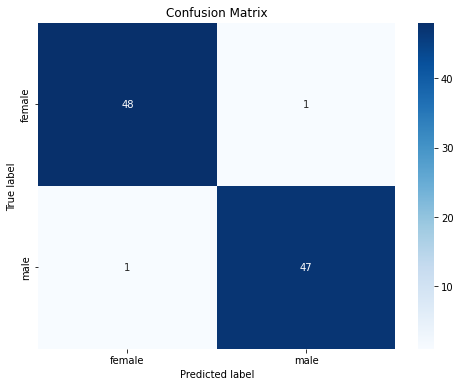

In [18]:
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#  Load Trained Model and Predict Gender Class from a New Image

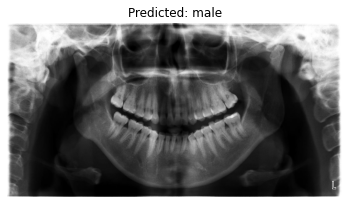

In [19]:
pipeline_loaded = joblib.load('log_reg_model.pkl')
encoder_loaded = joblib.load('label_encoder.pkl')

def preprocess_single_image(image_path, img_size):
    img = io.imread(image_path ,as_gray=True)  
    img_resized = resize(img, img_size, mode='reflect')  
    img_flattened = img_resized.flatten()  
    return np.array([img_flattened])  

image_path = "C:\\Users\\DELL 5540\\Desktop\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\test\\male\\male.447.JPG"
image_preprocessed = preprocess_single_image(image_path, img_size)

predicted_label_encoded = pipeline_loaded.predict(image_preprocessed)
predicted_label = encoder_loaded.inverse_transform(predicted_label_encoded)
plt.imshow(io.imread(image_path), cmap='gray')
plt.title(f'Predicted: {predicted_label[0]}')
plt.axis('off')  
plt.show()